In [140]:
import numpy as np
import pandas as pd

# libraries for plotting graphs/animations
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
from IPython.display import HTML

import time
import random
from statistics import mean, median
from math import sqrt

In [ ]:
# to enable the matplotlib animation to render on jupyter notebook
# !conda install -c conda-forge ffmpeg

In [66]:
def genTrajectory(NUM_POINTS = 20):
    # randomly generate distance to take for each time step
    x_points = np.array([random.randrange(start=-50, stop=100) for i in range(NUM_POINTS)])/100
    y_points = np.array([random.randrange(start=-50, stop=100) for i in range(NUM_POINTS)])/100
    t_points = np.array([random.randrange(start=0, stop=1000) for i in range(NUM_POINTS)])/100
    rad_inacc = np.array([random.randrange(start=0, stop=100) for i in range(NUM_POINTS)])/100
    
    # trajectory is just a 3D array of latitude, longitude, time
    traj = np.zeros(shape=(NUM_POINTS+1,4))

    for i in range(1, NUM_POINTS+1):
        traj[i,0] = traj[i-1,0] + x_points[i-1]
        traj[i,1] = traj[i-1,1] + y_points[i-1]
        traj[i,2] = traj[i-1,2] + t_points[i-1]
        
    traj[0,3] = random.randrange(start=0,stop=100)/100
    traj[1:,3] = rad_inacc
    
    traj = pd.DataFrame(traj)
    traj.columns = ["lon", "lat", "time", "inacc_radius"]
    
    return traj

# Noise Filtering with mean and median filter

In [67]:
traj = genTrajectory()
traj.head()

,lon,lat,time,inacc_radius
0,0.00,0.00,0.00,0.09
1,0.44,-0.48,9.29,0.61
2,0.10,0.46,12.62,0.17
3,1.04,0.10,16.81,0.58
4,0.56,-0.08,22.87,0.83


In [4]:
def filter(traj, index, filter_type, window_size=3):
    '''
    :param traj: a dataframe representing a series of lat-lon-time data
    :param index: the index of the lat-lon that we want to filter/smoothen
    :param window_size: the number of lat-lon values proceeding and preceeding the indexed lat-lon to consider
    :param filter_type: "median" or "mean" filter
    :return: a 3D array with lat-lon-time, time is unchanged, lat-lon is based on the filter
    '''
    
    # we don't modify the start and endpoint of our trajectory
    if index == len(traj)-1:
        return traj.iloc[-1,:]
    if index == 0:
        return traj.iloc[0,:]
    
    x_coors = []
    y_coors = []
    
    # collect the datapoints within the desired window
    for i in range(max(0, index-window_size), min(len(traj), index+window_size+1)):
        if i==index:
            continue
        x_coors.append(traj.lon[i])
        y_coors.append(traj.lat[i])
        
    if filter_type == "mean":
        return [mean(x_coors), mean(y_coors), traj.time[index]]
    elif filter_type == "median":
        return [median(x_coors), median(y_coors), traj.time[index]]

## Some functions to aid in plotting some trajectories and other information

In [5]:
def plot_traj(traj):
    '''
    :param traj: trajectory
    :return:
    plots the trajectory
    '''
    plt.figure(figsize=(8,8))
    plt.title("Trajectory")
    plt.plot(traj.lon, traj.lat, '-bo')
    plt.xlabel("longitude")
    plt.ylabel("latitude")
    
def plot_filtered_traj(traj, mean_traj, median_traj, window_size):
    '''
    :param traj: trajectory
    :param mean_traj: trajectory after applying mean filter
    :param median_traj: trajectory after applying median filter
    :param window_size: window size used in the filters
    :return:
    plots the mean filtered trajectory and median filtered trajectory side-by-side
    '''
    fig, axs = plt.subplots(1, 2, figsize=(16,8))
    
    plt.suptitle("Filters of window size " + str(window_size))
    
    axs[0].plot(traj.lon, traj.lat, '-bo')
    axs[0].plot(mean_traj[:,0], mean_traj[:,1], '--ro')
    axs[0].set_title("Randomly generated trajectory\n(mean filtered)")
    axs[0].legend(["Original trajectory", "Mean filtered trajectory"], loc='best')

    axs[1].plot(traj.lon, traj.lat, '-bo')
    axs[1].plot(median_traj[:,0], median_traj[:,1], '--ro')
    axs[1].set_title("Randomly generated trajectory\n(median filtered)")
    axs[1].legend(["Original trajectory", "Median filtered trajectory"], loc='best')

    for ax in axs.flat:
        ax.set(xlabel='longitude', ylabel='latitude')

## Comparing the performance of mean filter and median filter

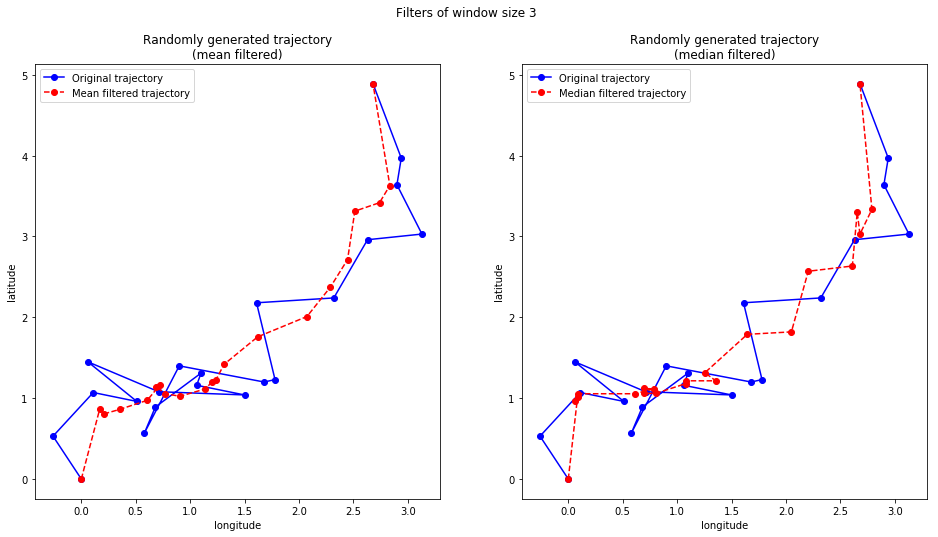

In [6]:
mean_traj = np.array([filter(traj=traj, index=i, filter_type="mean") for i in range(len(traj))])
median_traj = np.array([filter(traj=traj, index=i, filter_type="median") for i in range(len(traj))])

plot_filtered_traj(traj, mean_traj, median_traj, 3)

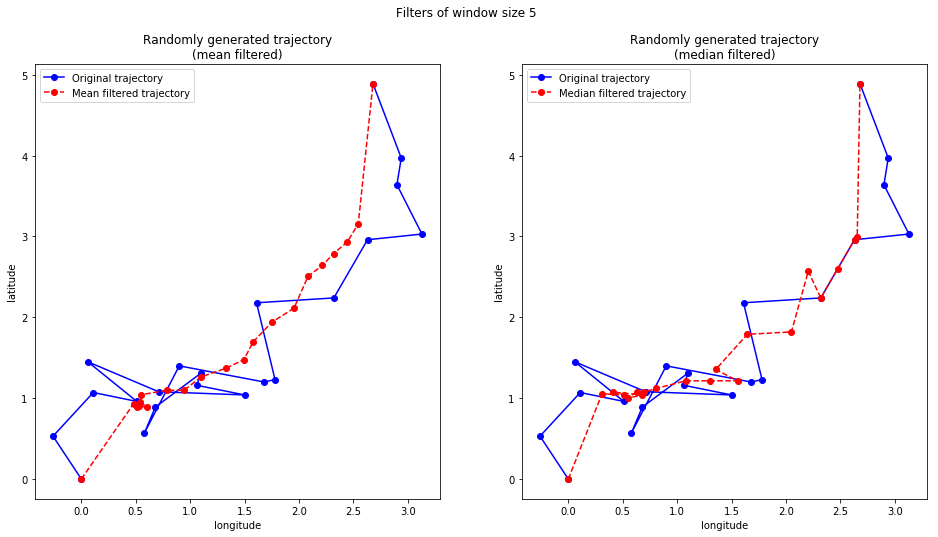

In [7]:
mean_traj = np.array([filter(traj=traj, index=i, window_size=5, filter_type="mean") for i in range(len(traj))])
median_traj = np.array([filter(traj=traj, index=i, window_size=5, filter_type="median") for i in range(len(traj))])

plot_filtered_traj(traj, mean_traj, median_traj, 5)

# Stay Point Detection Algorithm

In [20]:
class stayPoint:
    def __init__(self, arrivalTime, departTime, startIndex, endIndex, radius, location):
        self.arrivalTime = arrivalTime
        self.departTime = departTime
        self.radius = radius
        self.startIndex = startIndex
        self.endIndex = endIndex
        self.location = location
        
    def toString(self):
        print(f"({self.arrivalTime},{self.departTime},{self.startIndex},{self.endIndex},{self.radius},{self.location})")

In [23]:
def SPDA(traj, distThres, timeThres, minPoints):
    '''
    :param traj: a trajectory
    :param distThres: a threshold of the distance
    :param timeThres: a threshold of the time
    :param minPoints: the minimum no. of points required in a stay-point region
    :output: a set of stay-points
    '''
    def distance(pointA, pointB):
        '''
        :param pointA: a point with lat and lon variables
        :param pointB: a point with lat and lon variables
        :return: the distance between pointA and pointB calculated by Pythagoras Theorem
        '''
        return sqrt((pointA.lon - pointB.lon)**2 + (pointA.lat - pointB.lat)**2)
    
    def getCentroid(points, centroid_type):
        '''
        :param points: a list of points with lat and lon variables
        :param centroid_type: "median" or "mean"
        :return: the centre of the list of points, calculated by centroid_type function
        '''
        print("centroid points:\n", points)
        if centroid_type == "median":
            return [median(points.loc[:,"lon"]), median(points.loc[:,"lat"])]
        elif centroid_type == "mean":
            return [mean(points.loc[:,"lon"]), mean(points.loc[:,"lat"])]
        
    def getRadius(points, center):
        '''
        :param points: a list of points with variables lat and lon
        :param center: center of the desired circle
        :return: radius. The circle with radius and center will cover all points
        '''
        points = points.reset_index()
        distDiff = []
        for i in range(len(points)):
            distDiff.append(sqrt((points.lon[i] - center[0])**2 + (points.lat[i] - center[1])**2))
        
        return max(distDiff)
        
    i = 0
    pointNum = len(traj)
    stayPoints = []
    
    while i < pointNum:
        j = i+1
        token = 0
        while j < pointNum:
            dist = distance(traj.iloc[j,:], traj.iloc[i,:])
            if dist < distThres:
                timeDiff = traj.time[j] - traj.time[i]
                if timeDiff > timeThres and j >= i+minPoints:
                    centroid = getCentroid(traj.loc[i:j,:], "mean")
                    radius = getRadius(traj.loc[i:j,:], centroid)
                    print(i,j)
                    stayPoints.append(
                        stayPoint(
                            arrivalTime = traj.time[i], 
                            departTime = traj.time[j], 
                            startIndex = i,
                            endIndex = j,
                            radius = radius,
                            location = centroid
                        )
                    )
                    
                    i = j
                    token = 1
                break
            j += 1
            
        if token != 1:
            i += 1
            
    return stayPoints

In [24]:
stayPoints = SPDA(traj, 0.5, 0.5, 2)

centroid points:
     lon   lat   time
3  0.51  0.96  21.56
4  0.06  1.45  27.19
5  0.71  1.08  33.43
3 5
centroid points:
     lon   lat   time
5  0.71  1.08  33.43
6  1.50  1.04  42.87
7  1.06  1.16  49.07
5 7
centroid points:
      lon   lat   time
8   1.10  1.31  57.06
9   0.68  0.89  60.78
10  0.58  0.57  67.41
11  0.90  1.40  71.35
8 11


In [25]:
# arrivalTime, departTime, startIndex, endIndex, radius, location

for stayPoint in stayPoints:
    stayPoint.toString()

(21.56,33.43,3,5,0.46542692468552155,[0.42666666666666664, 1.1633333333333336])
(33.43,49.07,5,7,0.41345428337900236,[1.09, 1.0933333333333335])
(57.06,71.35,8,11,0.5277132270466601,[0.8150000000000002, 1.0425])


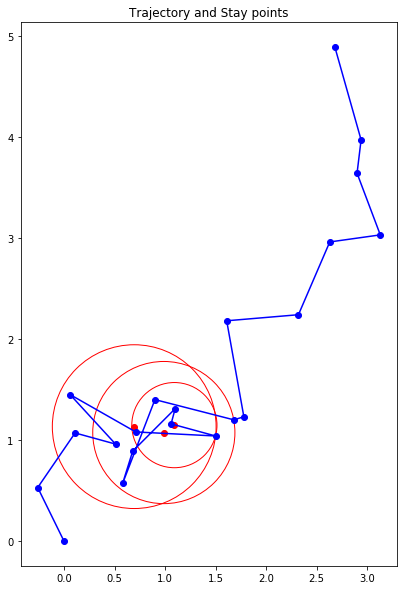

In [12]:
plt.figure(figsize=(10,10))
ax = plt.gca()

for point in stayPoints:
    plt.plot([point.location[0]], [point.location[1]], 'ro')
    draw_circle = plt.Circle((point.location[0], point.location[1]), point.radius, fill=False, color='r')
    ax.add_artist(draw_circle)

plt.title('Trajectory and Stay points')
plt.plot(traj.lon, traj.lat, '-bo')
ax.set_aspect(1.0)  # make aspect ratio square

plt.show()

# Matplotlib animations

In [176]:
np.linspace??

In [320]:
def animateTwoPts(startPoint, destPoint):

    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_axes([0, 0, 1, 1], frameon=False)
    ax.set_xlim(startPoint[0], destPoint[0]), ax.set_xticks([])
    ax.set_ylim(startPoint[1], destPoint[1]), ax.set_yticks([])

    def init():
        line.set_data([], [])
        return line,

    # animation function.  This is called sequentially
    def animate(i):
        t = np.linspace(0, i/100, i)
        x = t*destPoint[0] + (1-t)*startPoint[0]
        y = t*destPoint[1] + (1-t)*startPoint[1]

        line.set_data(x, y)
        return line,

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=100, interval=20, blit=True)
    plt.close()
    
    return HTML(anim.to_html5_video())

def movingCircles(startPoints, destPoints, radii, frames=20):
    NUM_POINTS = len(startPoints)
    
    # Create new Figure and an Axes which fills it.
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_axes([0, 0, 1, 1])

    x_start = min(min(startPoints[:,0]), min(destPoints[:,0]))
    x_end = max(max(startPoints[:,0]), max(destPoints[:,0]))
    y_start = min(min(startPoints[:,1]), min(destPoints[:,1]))
    y_end = max(max(startPoints[:,1]), max(destPoints[:,1]))

    ax.set_xlim(x_start, x_end)
    ax.set_xticks(np.linspace(x_start, x_end, 10))
    ax.set_ylim(y_start, y_end)
    ax.set_yticks(np.linspace(y_start, y_end, 10))

    # Construct the scatter which we will update during animation
    # as the raindrops develop.
    scat = ax.scatter(startPoints[:,0], startPoints[:,1], s=radii*1000, lw=0.5, edgecolors='b', facecolors='none')
    
    def updateOnept(start, end, i):
        t = np.linspace(0, 1, frames+1)
        x = t[i]*end[0] + (1-t[i])*start[0]
        y = t[i]*end[1] + (1-t[i])*start[1]
        
        return np.array([x,y])
    
    def update(i):
        updated_pts = np.zeros((NUM_POINTS,2))
        
        for j in range(NUM_POINTS):
            updated_pts[j] = updateOnept(startPoints[j], destPoints[j], i)

        # Update the scatter collection, with the new colors, sizes and positions.
        scat.set_offsets(updated_pts)
        return scat

    # Construct the animation, using the update function as the animation director.
    anim = animation.FuncAnimation(fig, update, frames=frames)
    plt.close()
    return HTML(anim.to_html5_video())

In [322]:
NUM_POINTS = 50

startPoints = np.random.ranf(size=(NUM_POINTS,2)) * np.random.randint(0,100) + np.random.randint(0,100)
destPoints = np.random.ranf(size=(NUM_POINTS,2)) * np.random.randint(0,100) + np.random.randint(0,100)
radii = np.random.ranf(size=(NUM_POINTS,1))*2

movingCircles(startPoints, destPoints, radii)